In [1]:
import os
from google.colab import files, output, drive
drive.mount('/gdrive')
%cd /gdrive
print("You're on Google Colab")
if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET4':
    os.chdir('My Drive/--DATA SCIENCE/PROJET4')
!pip install -r requirements_modelling.txt

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
You're on Google Colab
     |████████████████████████████████| 81kB 3.1MB/s 
  Created wheel for gTTS-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4097 sha256=80172d51d14319e55d1ae808485a4724338fd8a5aed40aec0a72ce6267bc9a62
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
Successfully built gTTS-token


In [2]:
from P4_functions import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import io
from time import time
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'
import warnings
warnings.filterwarnings('ignore')
import dill
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import category_encoders as ce
import scipy.stats as st
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.linear_model import *
from sklearn import metrics
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

In [4]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 500,
                    'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
    pd.set_option(k,v)

In [5]:
from IPython.display import Audio
from gtts import gTTS

def speak(text, lang='en'):
    with io.BytesIO() as f:
        gTTS(text=text, lang=lang).write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [6]:
path_csv = 'DATA/Cleaned_data.csv' 
# Importing database from my Drive
print("2. Try to import in notebook from myDrive...")

df = pd.read_csv(path_csv, sep=',', index_col='Unnamed: 0',
                 low_memory=True, encoding ='utf-8')

print("-----> importation of .csv in the notebook OK")

2. Try to import in notebook from myDrive...
-----> importation of .csv in the notebook OK


In [7]:
df['ZipCode'] = df['ZipCode'].apply(str).astype('object')
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].apply(str).astype('object')

In [8]:
speak('importations done')

In [9]:
# print("before", df.shape)
# df = df[df['PropertyGFATotal'].between(df['PropertyGFATotal'].mean()-3*df['PropertyGFATotal'].std(),
#                                      df['PropertyGFATotal'].mean()+3*df['PropertyGFATotal'].std())]
# print("after", df.shape)

In [10]:
# print("before", df.shape)
# df = df[df['SiteEnergyUseWN(kBtu)'].between(df['SiteEnergyUseWN(kBtu)'].mean()-3*df['SiteEnergyUseWN(kBtu)'].std(),
#                                      df['SiteEnergyUseWN(kBtu)'].mean()+4*df['SiteEnergyUseWN(kBtu)'].std())]
# print("after", df.shape)

In [11]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
               'ExtsurfVolRatio'] # 'ENERGYSTARScore',
prop_C_cols = ['Neighborhood', 'ZipCode', 'CouncilDistrictCode',
               'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
               'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
               'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy', 'Outlier']
target_cols = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions',
                'SiteEnergyUseWN(kBtu)_log', 'TotalGHGEmissions_log']

In [12]:
df_X = df[prop_Q_cols+prop_C_cols]
df_y = df[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']]

In [13]:
group_col = 'PrimaryPropertyType'

X_tr, X_te, y_tr, y_te = train_test_split(df_X, df_y,
                                            train_size=0.8, shuffle=True,
                                            stratify=df[group_col],
                                            random_state=14)

In [14]:
dict_SEU_models = load_pickle("P4_models_SEU.pkl")
dict_SEU_lcurves = load_pickle("P4_lcurves_SEU.pkl")
dict_SEU_pimp = load_pickle("P4_pimp_SEU.pkl")

--Pickle containing models already existing as  P4_models_SEU.pkl :
 dict_keys(['KNN_log_kneigh_grid', 'KNN_kneigh_grid', 'KNN_kbest_grid', 'KNN_log_kbest_grid', 'Ridge_alpha_enc_rand', 'KNN_pca_grid', 'KNN_log_pca_grid', 'Ridge_log_alpha_enc_rand', 'RandomForest_leaf_nest_grid', 'RandomForest_log_leaf_nest_grid', 'SVR_lin e_c_rand', 'KNN_xout_kneigh_grid'])
Content loaded from ' P4_models_SEU.pkl '.
--Pickle containing models already existing as  P4_lcurves_SEU.pkl :
 dict_keys(['KNN_kneigh_grid', 'KNN_log_kneigh_grid'])
Content loaded from ' P4_lcurves_SEU.pkl '.
--Pickle containing models already existing as  P4_pimp_SEU.pkl :
 dict_keys(['KNN_kneigh_grid', 'KNN_log_kneigh_grid', 'Ridge_alpha_enc_rand', 'Ridge_log_alpha_enc_rand'])
Content loaded from ' P4_pimp_SEU.pkl '.


In [15]:
df_res = pd.DataFrame(dtype = 'object')

In [16]:
skf = list(StratifiedKFold(5).split(X_tr, X_tr[group_col]))

In [17]:
dict_models = dict_SEU_models
dict_lcurves = dict_SEU_lcurves
dict_pimp = dict_SEU_pimp

In [18]:
models_file_name = 'P4_models_SEU_3.pkl'
l_curves_file_name = 'P4_l_curves_SEU_3.pkl'
perm_imp_file_name = 'P4_models_SEU_3.pkl'

# MODELS

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor()
name_reg = 'test'
# del dict_models[name_reg] # to overwrite an existing model
param_grid={'preproc__cust_trans__strat_binary': ['ord'],
            'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
            'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
            name_reg+'__n_neighbors': [1,2,3,4,5,7,9,11,15,17], # 1,2,3,5,7,9,11,15,17
            name_reg+'__p': [1,2]} # 1,2
search_strat = 'grid'
n_iter=None
refit_score='r2'

preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
pipe = Pipeline([('preproc', preproc_pipe),
	             (name_reg, reg)])
dict_scv_params, _, _, _ = \
        set_dict_scv_params(X_tr, y_tr, 'SEU', log_on=False, refit=refit_score)

df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
                          pipe, dict_scv_params, skf, df_res, search_strat, n_iter)
'''-----Model not existing - computing...
Grid
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.5min finished
-----...model dumped'''

-----Model not existing - computing...
Grid
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
exception calling callback for <Future at 0x7f1f1910a4e0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
ModuleNotFoundError: No module named 'P4_functions'
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 347, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/

BrokenProcessPool: ignored

In [ ]:
dict_models[name_reg].best_params_

{'KNN_kneigh_grid__n_neighbors': 3,
 'KNN_kneigh_grid__p': 1,
 'preproc__cust_trans__strat_binary': 'ord',
 'preproc__cust_trans__strat_high_card': 'ohe',
 'preproc__cust_trans__strat_low_card': 'ohe',
 'preproc__cust_trans__strat_quant': 'stand'}

Showing the different scores vs n_neighbors hyperparameter (other parameters set to best parameters)

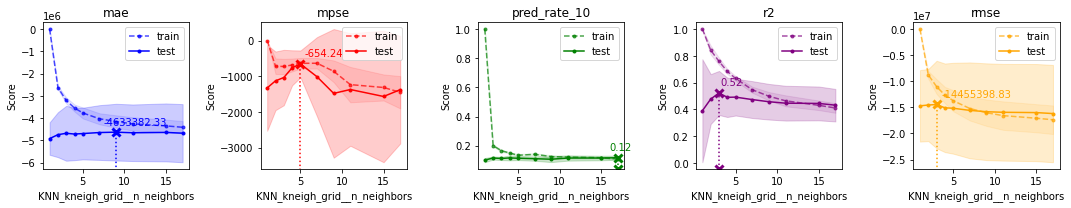

In [ ]:
scv = dict_models[name_reg]
plot_scv_multi_scores(name_reg, scv, param = name_reg+'__n_neighbors',
                      title = None, figsize = (15, 3))

The n_neighbor parameter that optimizes r2 score is k=3

- Showing influence of both hyperparameters on one the refit_score.

_NB: The score displayed for each cell is the one for the best other parameters_

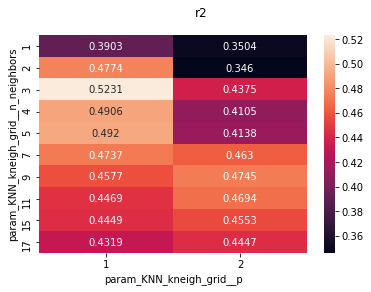

In [ ]:
param1 = name_reg+'__'+'n_neighbors'
param2 = name_reg+'__'+'p'
params = [param1, param2]

plot_2D_hyperparam_opt(scv=dict_models[name_reg], params=params,
                       score = 'r2')

The best minkowski metric for the distance is Manhattan (1).

- Plotting the learning curve of the best estimator (with r2 score)

-----Learning curve already exists - taking existing learning curve


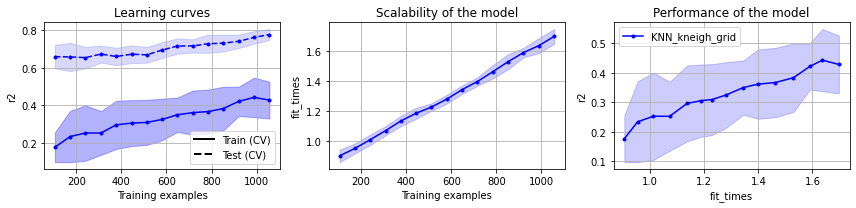

In [ ]:
# del dict_lcurves[name_reg] # to overwrite an existing learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(12, 3));
# title = f"Learning Curves ({name_reg})"
model = dict_models[name_reg].best_estimator_
plot_learning_curve(name_reg, model, dict_scv_params['X'], dict_scv_params['y'], #ylim=(0.7, 1.01),
                    cv=cv, scoring=r2, score_name='r2', #n_jobs=4,
                    file_name=l_curves_file_name,
                    dict_learn_curves=dict_lcurves,
                    train_sizes = np.linspace(0.1,1,15),
                    c='b', axes=axes, title=None)
plt.show()

The learning curve shows that the model still continues to learn after 1300 observation. The lack of data may be the cause of the relatively bad results.

#### Dealing with outliers...

- élimination via zscore (réglage du seuil)
- élimination via IsolationForest
- aiguillage vers 2 modèles en utilisant IsolationForest

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsRegressor

# reg = KNeighborsRegressor()
# name_reg = 'KNN_out_kneigh_grid'
# # del dict_models[name_reg] # to overwrite an existing model
# param_grid={'preproc__cust_trans__strat_binary': ['ord'],
#             'preproc__cust_trans__strat_low_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_high_card': ['ohe'], # 'ohe', 'bin', 'ord', 'hash', 'loo'
#             'preproc__cust_trans__strat_quant': ['stand'], # 'stand', 'minmax', 'maxabs', 'robust', 'norm', 'quant_uni', 'quant_norm', 'pow'
#             # 'outliers__threshold': [],
#             name_reg+'__n_neighbors': [1,2,], # 3,4,5,7,9,11,15,17
#             name_reg+'__p': [1,2]} # 1,2
# search_strat = 'grid'
# n_iter=None
# refit_score='r2'

# preproc_pipe = Pipeline([('cust_trans', CustTransformer(thresh_card=12))])
# pipe = Pipeline([('preproc', preproc_pipe),
#                  ('outliers', OutlierExtractor()),
# 	             (name_reg, reg)])
# dict_scv_params, models_file_name, l_curves_file_name, perm_imp_file_name = \
#         set_dict_scv_params(X_tr, y_tr, 'SEU', log_on=False, refit=refit_score)

# df_res = run_optimization(name_reg, reg, param_grid, models_file_name, dict_models,
#                           pipe, dict_scv_params, skf, df_res, search_strat, n_iter)
# pipe.get_params()

NameError: ignored

In [ ]:
OutlierExtractor(threshold=0.2)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

"""  Create a transformer to remove outliers. A threshold is set for selection
        criteria, and further arguments are passed to the LocalOutlierFactor class
        Keyword Args:
            neg_conf_val (float): The threshold for excluding samples with a lower
               negative outlier factor.
        Returns:
            object: to be used as a transformer method as part of Pipeline()
"""

class OutlierExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.threshold = kwargs.pop('neg_conf_val', -10.0)
        self.kwargs = kwargs

    def transform(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        lcf = LocalOutlierFactor(**self.kwargs)
        lcf.fit(X)
        return (X[lcf.negative_outlier_factor_ > self.threshold, :],
                y[lcf.negative_outlier_factor_ > self.threshold])

    def fit(self, X, y, *args, **kwargs):
        return self